# DRAFT GROUP 8, AIMS 2024, MMED

0. LOAD THE NECESSARY LIBRARIES

In [1]:
#Remove all objects in memory
rm(list = ls())

In [3]:
# Libraries
library(deSolve)
library(tidyverse)
library(tidyr)


 1. LOADING AND EXPLORING THE DATA


In [4]:
# Get the current directory
getwd()

[1] "/var/autofs/misc/home/emmanuelnk/Desktop/MMED/FINAL_RESULTS"

In [5]:
# Define the path towards a new directory
path <- "/home/emmanuelnk/Desktop/MMED/TUTORIALS/"

In [6]:
# Set the working directory to the specified path
setwd(path)

In [7]:
# Loading the data
load("dataLondon.Rdata")

In [8]:
# Confirm the dataset is loaded by listing the objects in the environment
ls()

[1] "London" "path"

In [9]:
# Inspect the first 5 rows of the London dataset
head(London, 5)

,year,pop,births,measles,wc,meas.inc,wc.inc
,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>
1,1946,7696580,158005,22880,6929,297.2749,90.02700
2,1947,7949780,165925,17835,9336,224.3458,117.43721
3,1948,8135380,140063,30604,10493,376.1840,128.97984
4,1949,8205310,129830,28794,5923,350.9191,72.18496
5,1950,8260440,121913,22274,10993,269.6467,133.08008


In [10]:
# Shows last 5 rows
tail(London, 5) 

,year,pop,births,measles,wc,meas.inc,wc.inc
,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>
42,1987,6755300,100525,4457,NA,65.97782,NA
43,1988,6735400,103380,8942,NA,132.76123,NA
44,1989,6756400,102467,2183,1242,32.31011,18.38257
45,1990,6794400,105702,1371,3926,20.17838,57.78288
46,1991,6803100,105813,1047,1744,15.39004,25.63537


In [11]:
# Shows variable names
names(London) 

[1] "year"     "pop"      "births"   "measles"  "wc"       "meas.inc" "wc.inc"

In [12]:
# Shape of our dataset:46X7
dim(London)

[1] 46  7

In [13]:
# Rows of our dataset
nrow(London)

[1] 46

In [14]:
# Columns of our dataset
ncol(London)

[1] 7

In [15]:
# Types (classes) of variables in our dataset
class(London$measles) # Nice: integer

[1] "integer"

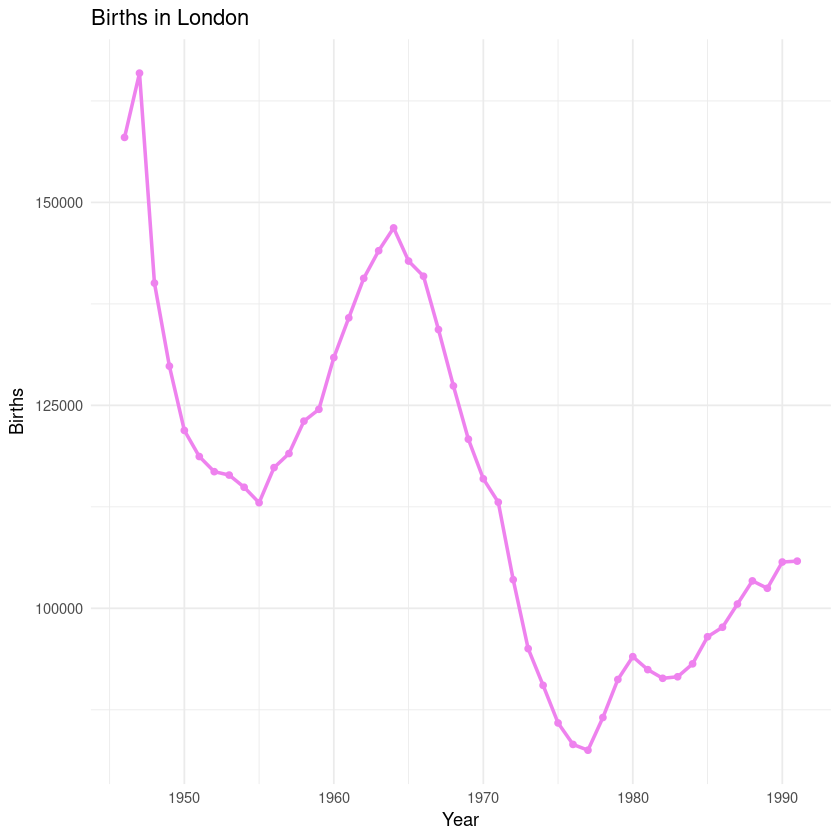

In [17]:
# Let's inspect the biths dynamics
births_london <- ggplot(London, aes(x = year, y = births)) +
  geom_point(color = "violet") +
  geom_line(color = "violet",size = 1) +
  labs(title = "Births in London",
       x = "Year",
       y = "Births") +
  theme_minimal()
print(births_london)

In [18]:
# Save the plot to a PDF file
ggsave(filename = "births_london_plot.pdf", plot = births_london, device = "pdf", path = path)

Saving 6.67 x 6.67 in image


In [19]:
# Mean of the column births
mean(London$births)

[1] 114481.9

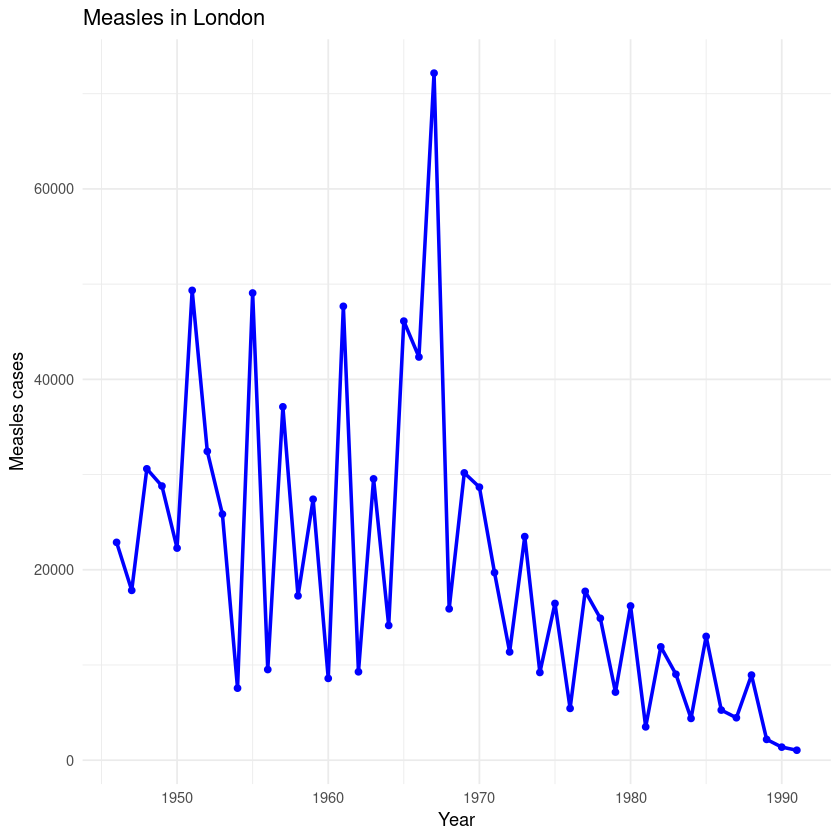

In [20]:
# Let's display the measles dynamics
measles_london <- ggplot(London, aes(x = year, y = measles)) +
  geom_point(color = "blue") +
  geom_line(color = "blue",size = 1) +
  labs(title = "Measles in London",
       x = "Year",
       y = "Measles cases") +
  theme_minimal()
print(measles_london)

In [21]:
# Save the plot to a PDF file
ggsave(filename = "measles_london_plot.pdf", plot = measles_london, device = "pdf", path = path)

Saving 6.67 x 6.67 in image


In [22]:
# Mean of the column measles
mean(London$measles)

[1] 20202.48

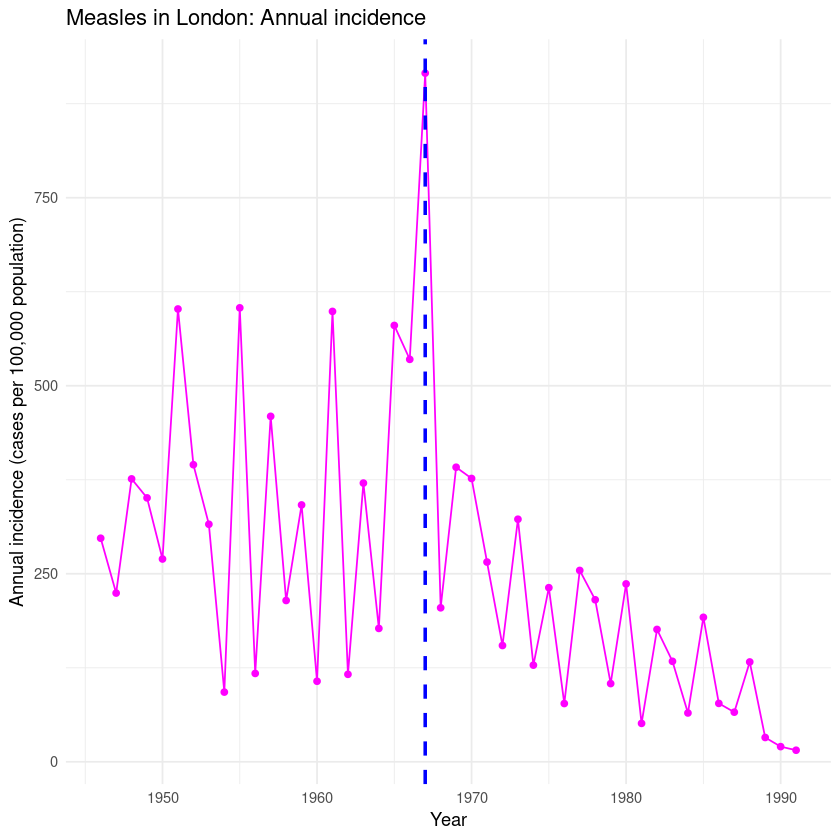

In [23]:
# Let's display the measles incidence plot
measles_plot <- ggplot(London, aes(x = year, y = meas.inc)) +
  geom_point(color = "magenta") +
  geom_line(color = "magenta") +
  labs(title = "Measles in London: Annual incidence",
       x = "Year",
       y = "Annual incidence (cases per 100,000 population)") +
  theme_minimal() +
  geom_vline(xintercept = 1967, color = "blue", linetype = "dashed", size = 1) # Add vertical line

print(measles_plot)

In [24]:
# Save the plot to a PDF file
ggsave(filename = "measles_incidence_vac_plot.pdf", plot = measles_plot, device = "pdf", path = path)

Saving 6.67 x 6.67 in image


# 2. SEIR MODEL IMPLEMENTATION

In [25]:
# 1. Define the SEIR model
seir_model <- function(t, y, parms) {
    
with(as.list(c(y, parms)), {

  dSdt <- nu*(1-vacc_rate) - (beta * S * I / N) 
  dEdt <- (beta * S * I / N) - (mu + sigma) * E
  dIdt <- (sigma * E) - (mu + gamma) * I
  dRdt <- (vacc_rate * nu) + (gamma * I) -(mu * R) 
  
  return(list(c(dSdt, dEdt, dIdt, dRdt)))

    })
}

In [26]:
# 2. Define the parameter

# Basic reproductive number
R_0 <- 13

# Latent period : days
latent_period <- 8

# sigma = 1/ latent_period 
sigma <- 1/latent_period

#Infectious period : days
infectious_period <- 5

# gamma = 1/ infectious_period 
gamma <- 1/infectious_period

#mu
mu = 0.02/365

# beta
beta <- R_0 / ((sigma / (mu + sigma)) * (1 / (mu + gamma))) # or beta = R_0 * gamma
#eta <-2.06
#3. Define the initial conditions

N0 = 114482 # Mean of variable births
E0 = 0.0005 * N0
R0= 0*N0
I0= 0.0001* N0
inits <- c(S=N0-I0-E0-R0,E =E0,I=I0,R=R0)


p = 0
nu = mu * N0

# The parameters
params <- c(beta = beta,N=N0,sigma=sigma,gamma = gamma,nu =nu,vacc_rate=p)
params

beta            N        sigma        gamma           nu    vacc_rate 
2.601852e+00 1.144820e+05 1.250000e-01 2.000000e-01 6.272986e+00 0.000000e+00

In [27]:
# 4. Define the time points to return results
dt <- seq(0, 80, by = 1)

In [28]:
#5. Solve the model
results <- lsoda(
y = inits,
times = dt,
func = seir_model,
parms = params
)

In [29]:
#6. Manipulate and interpret the results
# Make it a data.frame
results <- as.data.frame(results)
head(results)

,time,S,E,I,R
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,114413.3,57.24100,11.44820,0.000000
2,1,114382.6,85.43502,17.39526,2.845467
3,2,114332.9,128.21546,26.25790,7.151104
4,3,114254.9,192.72592,39.54977,13.641485
5,4,114134.3,289.77285,59.52053,23.412305
6,5,113950.1,435.56543,89.53252,38.112855


# Vaccination rate : p=0 or 0 %.

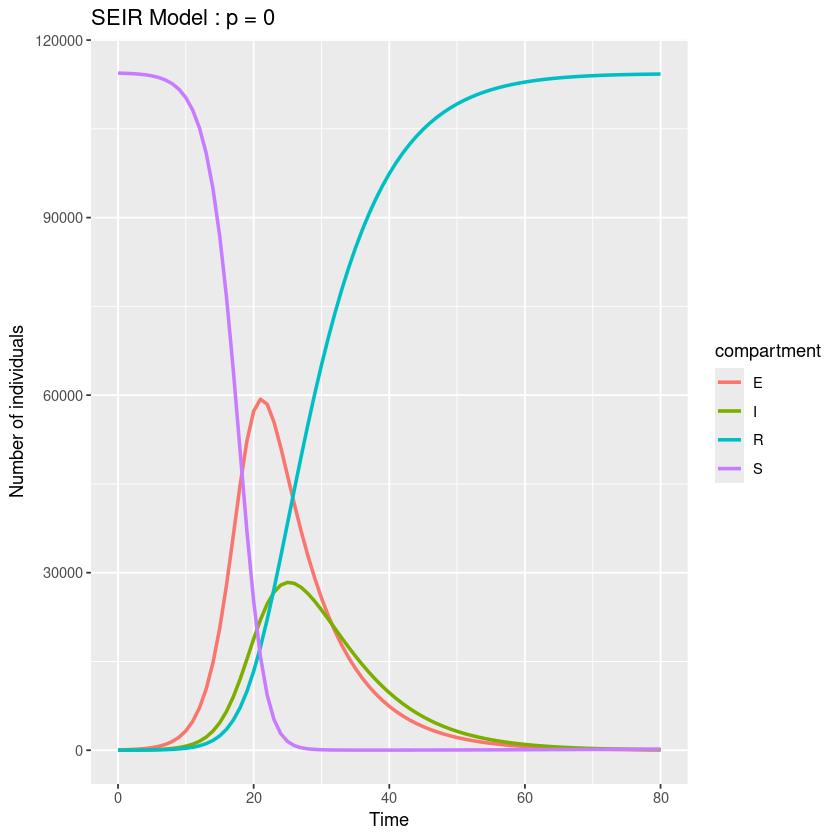

In [30]:
# Create data for ggplot2 by reshaping 
results_long <- results |>
pivot_longer(
cols = c(2:5),
names_to = "compartment",
values_to = "value"
)
seir_plot <- ggplot(
data = results_long,
aes(
x = time,
y = value,
color = compartment
)
) +
geom_line(linewidth = 1) +
labs(
title = paste("SEIR Model : p =",params[length(params)]),
x = "Time",
y = "Number of individuals"
)
plot(seir_plot)

# Vaccination rate : p=0.2 or 20 %.

,time,S,E,I,R
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,114413.3,57.24100,11.44820,0.000000
2,1,114381.3,85.43481,17.39525,4.100029
3,2,114330.4,128.21429,26.25782,9.660154
4,3,114251.1,192.72222,39.54945,17.404924
5,4,114129.3,289.76332,59.51953,28.429968
6,5,113943.8,435.54382,89.52997,44.384456


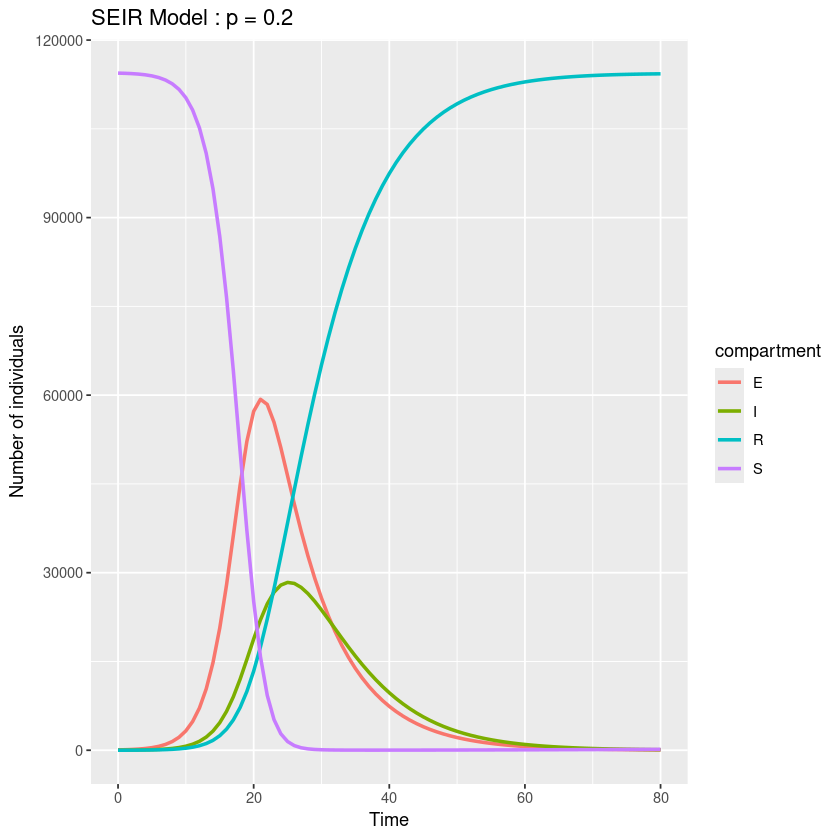

In [31]:
#actual vaccination_rate
p = 0.2

# actual parameters
params <- c(beta = beta,N=N0,sigma=sigma,gamma = gamma,nu =nu,vacc_rate=p)

#actual results
results <- lsoda(
y = inits,
times = dt,
func = seir_model,
parms = params
)
results <- as.data.frame(results)
head(results)

#plot
results_long <- results |>
pivot_longer(
cols = c(2:5),
names_to = "compartment",
values_to = "value"
)
seir_plot <- ggplot(
data = results_long,
aes(
x = time,
y = value,
color = compartment
)
) +
geom_line(linewidth = 1) +
labs(
title = paste("SEIR Model : p =",params[length(params)]),
x = "Time",
y = "Number of individuals"
)
plot(seir_plot)

# Vaccination rate : p=0.4 or 40 %.

,time,S,E,I,R
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,114413.3,57.24100,11.44820,0.000000
2,1,114380.1,85.43459,17.39525,5.354591
3,2,114327.9,128.21313,26.25774,12.169204
4,3,114247.4,192.71854,39.54913,21.168364
5,4,114124.3,289.75415,59.51860,33.447667
6,5,113937.6,435.52275,89.52753,50.656115


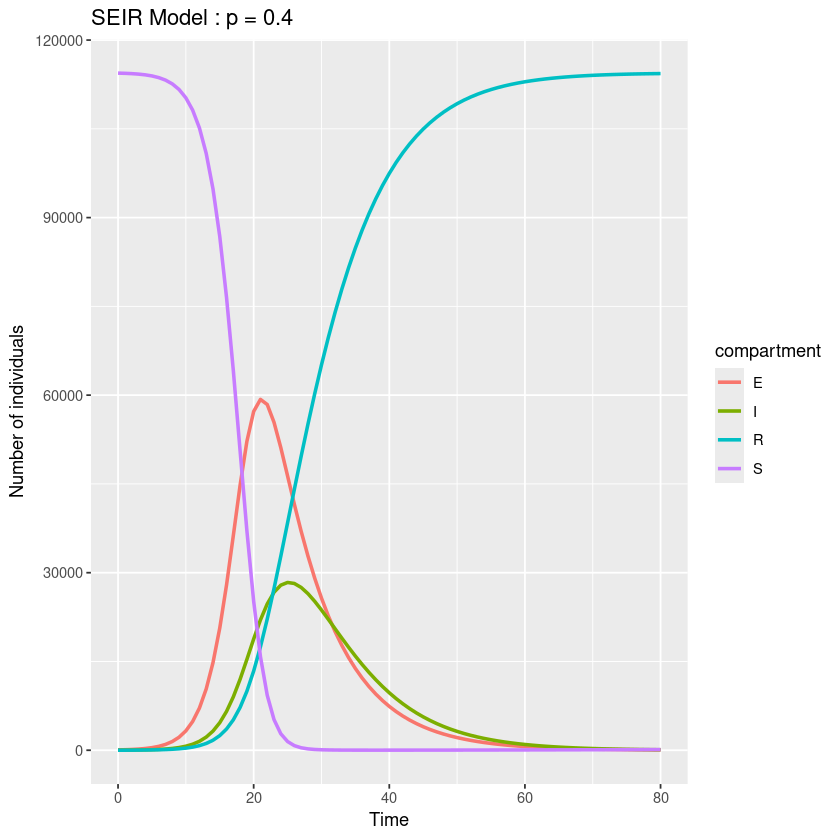

In [32]:
#actual vaccination_rate
p = 0.4

# actual parameters
params <- c(beta = beta,N=N0,sigma=sigma,gamma = gamma,nu =nu,vacc_rate=p)

#actual results
results <- lsoda(
y = inits,
times = dt,
func = seir_model,
parms = params
)
results <- as.data.frame(results)
head(results)

#plot
results_long <- results |>
pivot_longer(
cols = c(2:5),
names_to = "compartment",
values_to = "value"
)
seir_plot <- ggplot(
data = results_long,
aes(
x = time,
y = value,
color = compartment
)
) +
geom_line(linewidth = 1) +
labs(
title = paste("SEIR Model : p =",params[length(params)]),
x = "Time",
y = "Number of individuals"
)
plot(seir_plot)

# Vaccination rate : p=0.6 or 60 %.

,time,S,E,I,R
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,114413.3,57.24100,11.44820,0.000000
2,1,114378.8,85.43438,17.39524,6.609154
3,2,114325.4,128.21197,26.25767,14.678255
4,3,114243.6,192.71486,39.54881,24.931806
5,4,114119.3,289.74480,59.51763,38.465348
6,5,113931.3,435.50152,89.52506,56.927757


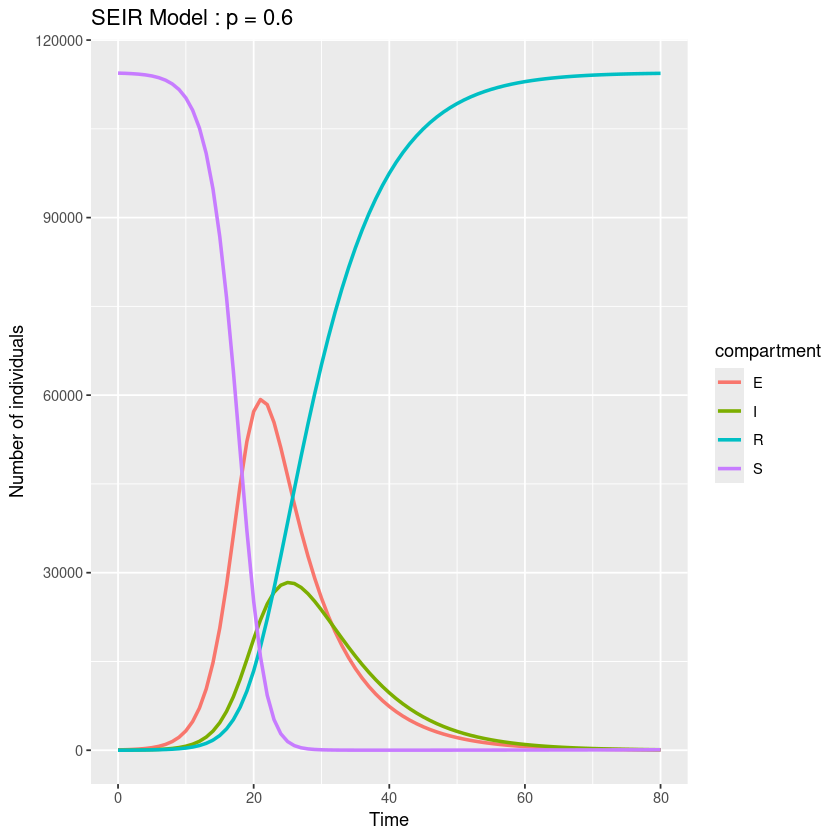

In [33]:
#actual vaccination_rate
p = 0.6

# actual parameters
params <- c(beta = beta,N=N0,sigma=sigma,gamma = gamma,nu =nu,vacc_rate=p)

#actual results
results <- lsoda(
y = inits,
times = dt,
func = seir_model,
parms = params
)
results <- as.data.frame(results)
head(results)

#plot
results_long <- results |>
pivot_longer(
cols = c(2:5),
names_to = "compartment",
values_to = "value"
)
seir_plot <- ggplot(
data = results_long,
aes(
x = time,
y = value,
color = compartment
)
) +
geom_line(linewidth = 1) +
labs(
title = paste("SEIR Model : p =",params[length(params)]),
x = "Time",
y = "Number of individuals"
)
plot(seir_plot)

# Vaccination rate : p=0.8 or 80 %.

,time,S,E,I,R
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,114413.3,57.24100,11.44820,0.000000
2,1,114377.6,85.43416,17.39523,7.863716
3,2,114322.9,128.21081,26.25759,17.187305
4,3,114239.8,192.71118,39.54849,28.695247
5,4,114114.3,289.73544,59.51666,43.483028
6,5,113925.1,435.48029,89.52259,63.199398


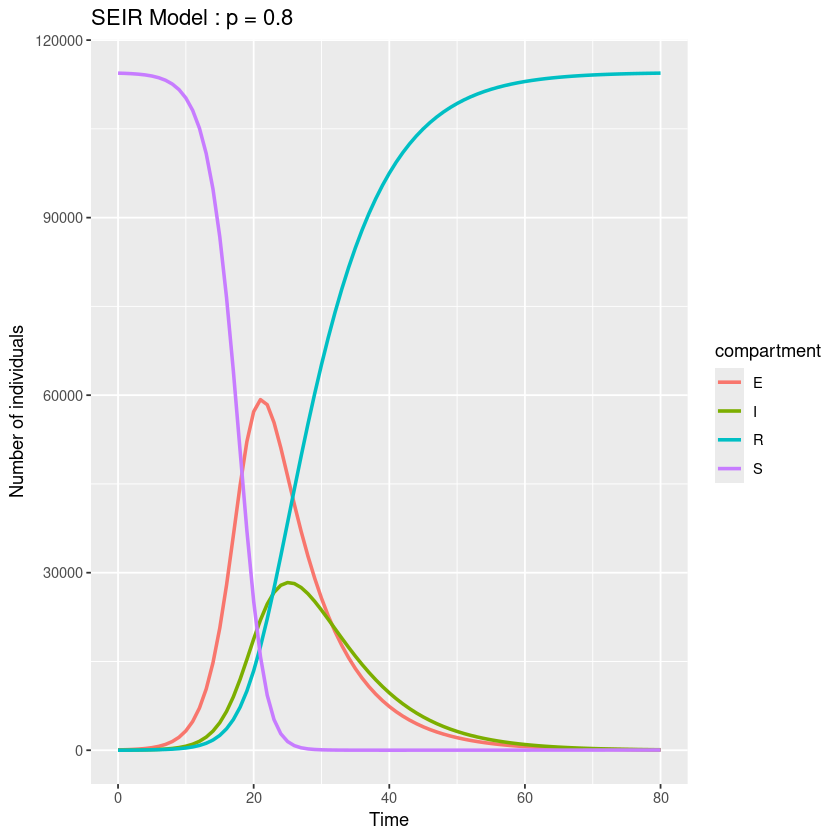

In [34]:
#actual vaccination_rate
p = 0.8

# actual parameters
params <- c(beta = beta,N=N0,sigma=sigma,gamma = gamma,nu =nu,vacc_rate=p)

#actual results
results <- lsoda(
y = inits,
times = dt,
func = seir_model,
parms = params
)

results <- as.data.frame(results)
head(results)

#plot
results_long <- results |>
pivot_longer(
cols = c(2:5),
names_to = "compartment",
values_to = "value"
)
seir_plot <- ggplot(
data = results_long,
aes(
x = time,
y = value,
color = compartment
)
) +
geom_line(linewidth = 1) +
labs(
title = paste("SEIR Model : p =",params[length(params)]),
x = "Time",
y = "Number of individuals"
)
plot(seir_plot)